In [ ]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [ ]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz


In [ ]:
from tools.misc_tools import create_Lorenz_data, create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data, plot_latent_states, readAndReturnLossHistories
from tools.ae_v3 import Autoencoder
from tools.LSTM_SingleStep_v1 import RNN_LSTM
from tools.Combined_AE_RNN_v1 import Combined_AE_RNN


In [ ]:
# behaviour = 'initialiseAndTrainFromScratch'
behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [ ]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [ ]:
tf.test.gpu_device_name()
tf.__version__

'2.8.2'

# Lorenz System

In [ ]:
# setting up params

from numpy import *

### Simutlation paramaters
if behaviour == 'initialiseAndTrainFromScratch':
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_010'
    dir_sim_data = dir_name_rnn
    dir_rnn_data = dir_name_rnn
else:
    dir_name_ae_rnn = os.getcwd()+'/saved_ae_rnn/ae_rnn_004'
    # dir_name_rnn = dir_name_ae_rnn + '{ds}initial_net{ds}RNN'.format(ds=dir_sep)
    # dir_name_ae = dir_name_ae_rnn + '{ds}initial_net{ds}AE'.format(ds=dir_sep)
    dir_sim_data = dir_name_ae_rnn
    dir_rnn_data = dir_name_ae_rnn

with open(dir_sim_data + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))


dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]

rho_arr = params_dict['rho_arr']
sigma_arr = params_dict['sigma_arr']
beta_arr = params_dict['beta_arr']

x0 = params_dict['x0']
y0 = params_dict['y0']
z0 = params_dict['z0']

t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']

normalize_flag = params_dict['normalize_flag']


### RNN paramaters
with open(dir_rnn_data + '/RNN_specific_data.txt') as f:
    lines = f.readlines()

params_rnn_dict = eval(''.join(lines))

dt_rnn = params_rnn_dict['dt_rnn']
T_sample_input = params_rnn_dict['T_sample_input']
T_sample_output = params_rnn_dict['T_sample_output']
T_offset = params_rnn_dict['T_offset']
return_params_arr = params_rnn_dict['return_params_arr']

In [ ]:
res_dict = create_Lorenz_data(
    T, t0, delta_t,
    rho_arr, sigma_arr, beta_arr,
    x0, y0, z0, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [ ]:
n = len(boundary_idx_arr)

# Autoencoder

In [ ]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

if behaviour == 'initialiseAndTrainFromScratch':
    load_file = dir_name_ae + '{ds}final_net{ds}'.format(ds=dir_sep)
elif behaviour == 'loadCheckpointAndContinueTraining':
    load_file = dir_name_ae_rnn + '{ds}initial_net{ds}AE{ds}'.format(ds=dir_sep)
elif behaviour == 'loadFinalNetAndPlot':
    load_file = dir_name_ae_rnn + '{ds}final_net{ds}AE{ds}'.format(ds=dir_sep)

wt_file = load_file + 'final_net_ae_weights.h5'
load_file += 'final_net_class_dict.txt'

In [ ]:
ae_net = Autoencoder(6, load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [ ]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

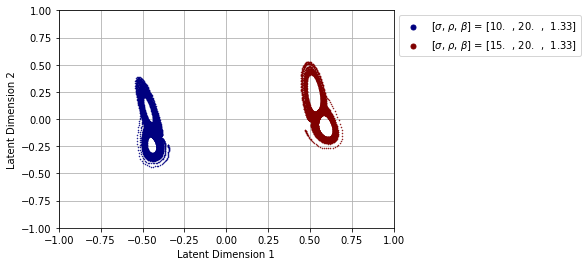

In [ ]:
fig, ax = plot_latent_states(
    boundary_idx_arr=boundary_idx_arr,
    latent_states_all=latent_states_all,
    all_data=all_data,
    xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='jet')

# LSTM

In [ ]:
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_load_file_path = dir_name_rnn+'{ds}final_net{ds}'.format(ds=dir_sep)
elif behaviour == 'loadCheckpointAndContinueTraining':
    rnn_load_file_path = dir_name_ae_rnn + '{ds}initial_net{ds}RNN{ds}'.format(ds=dir_sep)
elif behaviour == 'loadFinalNetAndPlot':
    rnn_load_file_path = dir_name_ae_rnn + '{ds}final_net{ds}RNN{ds}'.format(ds=dir_sep)

rnn_weights_path = rnn_load_file_path + 'final_net_lstm_weights.h5'
rnn_load_file_path += 'final_net_class_dict.txt'

In [ ]:
rnn_net = RNN_LSTM(load_file=rnn_load_file_path)
temp = rnn_net.predict(tf.ones(shape=[1, 1, rnn_net.data_dim]))
rnn_net.load_weights_from_file(file_name=rnn_weights_path)

# Combined Model

In [ ]:
if return_params_arr != False:
    params = params_arr
else:
    params = None

data_rnn_input, data_rnn_output, org_data_idx_arr_input, org_data_idx_arr_output = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    N,
    boundary_idx_arr,
    delta_t,
    params=params)

In [ ]:
# saving training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [0.0001, 0.00001]
    epochs = 2000
    patience = 50  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-5  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
else:
    with open(dir_name_ae_rnn+'/training_specific_params.txt', 'r') as f:
        lines = f.readlines()

    training_param_dict = eval(''.join(lines))

    learning_rate_list = training_param_dict['learning_rate_list']
    epochs = training_param_dict['epochs']
    patience = training_param_dict['patience']
    min_delta = training_param_dict['min_delta']
    prng_seed = training_param_dict['prng_seed']
    train_split = training_param_dict['train_split']
    val_split = training_param_dict['val_split']
    batch_size = training_param_dict['batch_size']
    test_split = 1 - train_split - val_split

    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)


In [ ]:
idx = np.arange(data_rnn_input.shape[0])
np.random.shuffle(idx)
boundary = int(np.round((1 - test_split)*data_rnn_input.shape[0]))

training_data_rnn_input = data_rnn_input[idx[0:boundary]]
training_data_rnn_output = data_rnn_output[idx[0:boundary]]

testing_data_rnn_input = data_rnn_input[idx[boundary:]]
testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [ ]:
# defining the combined model
combined_net = Combined_AE_RNN(
    data_dim=6,
    AE_net=ae_net,
    RNN_net=rnn_net)

In [ ]:
if behaviour == 'loadCheckpointAndContinueTraining':
    combined_net.load_weights(dir_name_ae_rnn+'{ds}checkpoints{ds}checkpoint'.format(ds=dir_sep))

In [ ]:
# saving some data
if behaviour == 'initialiseAndTrainFromScratch':
    dir_name_ae_rnn = os.getcwd() + dir_sep + 'saved_ae_rnn'
    if not os.path.isdir(dir_name_ae_rnn):
        os.makedirs(dir_name_ae_rnn)

    counter = 0
    while True:
        dir_check = 'ae_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae_rnn = dir_name_ae_rnn + dir_sep + dir_check
    print('AE-RNN save directory : ' + dir_name_ae_rnn)
    os.makedirs(dir_name_ae_rnn)
    os.makedirs(dir_name_ae_rnn+dir_sep+'plots')
    dir_name_data = {
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
    }

    with open(dir_name_ae_rnn+dir_sep+'ae_rnn_dirs.txt', 'w') as f:
        f.write(str(dir_name_data))

    with open(dir_name_ae_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(params_dict))

    with open(dir_name_ae_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(params_rnn_dict))

    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size
    }

    with open(dir_name_ae_rnn+'/training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))

    combined_net.save_everything(
        save_dir=dir_name_ae_rnn+dir_sep+'initial_net',
        dir_sep=dir_sep)

In [ ]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [ ]:
# compiling the network
combined_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=5  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=5)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(combined_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = combined_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
            validation_split=val_split/train_split,
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/1680
223/223 [==============================] - 98s 402ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 2/1680
223/223 [==============================] - 85s 381ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/1680
223/223 [==============================] - 84s 379ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/1680
223/223 [==============================] - 86s 386ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/1680
223/223 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 7m 19.4s

Epoch 5: val_loss improved from inf to 0.00164, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/saved_ae_rnn/ae_rnn_004/checkpoints/checkpoint
 - saving loss histories at /content/drive/MyDrive/Colab Notebo

KeyboardInterrupt: ignored

In [ ]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = combined_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_ae_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))

    combined_net.save_everything(
        save_dir=save_path,
        dir_sep=dir_sep)

In [ ]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

# plt.savefig(dir_name_ae_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# new latent states
latent_states_new = combined_net.AE_net.encoder_net.predict(all_data)

In [ ]:
fig, ax = plot_latent_states(
    boundary_idx_arr=boundary_idx_arr,
    latent_states_all=latent_states_new,
    all_data=all_data,
    xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='jet')

plt.savefig(dir_name_ae_rnn + '{ds}plots{ds}latent_space_new.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')

In [ ]:
# reconstructed data
reconstructed_data = combined_net.AE_net.predict(all_data)

In [ ]:
fig = plot_reconstructed_data(
    boundary_idx_arr=boundary_idx_arr,
    dir_name_ae=dir_name_ae_rnn,
    all_data=all_data,
    reconstructed_data=reconstructed_data,
    save_figs=False)

In [ ]:
plot_reconstructed_data(
    boundary_idx_arr=boundary_idx_arr,
    dir_name_ae=dir_name_ae_rnn,
    all_data=all_data,
    reconstructed_data=reconstructed_data,
    save_figs=True)